In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

In [4]:
shotchart_cur = ShotChartDetail(team_id=0, player_id=0, season_nullable='2020-21', season_type_all_star='Regular Season').get_data_frames()[0]

In [6]:
shotchart_cur.loc[:, 'SEASON'] = '2020-21'

In [9]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(1999, 2021)]

In [24]:
shots = []

for season in seasons:
    if season == '2020-21':
        shots.append(shotchart_cur)
        continue
    shot_df = pd.read_csv(f'shots/{season}.csv')
    del(shot_df['Unnamed: 0'])
    shot_df.loc[:, 'SEASON'] = season
    shots.append(shot_df)

In [25]:
full_df = pd.concat(shots)

In [26]:
grouped_df = full_df.groupby(['PLAYER_NAME', 'SEASON', 'SHOT_ZONE_BASIC']).agg(
    {
        'SHOT_MADE_FLAG': 'sum',
        'SHOT_ATTEMPTED_FLAG': 'sum',
    }
)

In [28]:
grouped_df = grouped_df.reset_index()

In [32]:
summed = grouped_df.groupby(['PLAYER_NAME', 'SEASON']).SHOT_ATTEMPTED_FLAG.sum().reset_index()

In [35]:
summed = summed.rename(columns={'SHOT_ATTEMPTED_FLAG': 'TOTAL_SHOTS'})

In [37]:
merged_df = pd.merge(left=grouped_df, right=summed, on=('PLAYER_NAME', 'SEASON'))

In [41]:
merged_df.loc[:, 'SHOT_PCT'] = (merged_df.SHOT_ATTEMPTED_FLAG / merged_df.TOTAL_SHOTS) * 100

In [80]:
base_dfs = []
for season in seasons:
    base_df = LeagueDashPlayerStats(season=season, per_mode_detailed='PerGame').get_data_frames()[0]
    base_df = base_df.loc[(base_df.PTS >= 20) & (base_df.GP > 10)]
    base_df = base_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'PTS']]
    base_df.loc[:, 'SEASON'] = season
    time.sleep(0.25)
    base_dfs.append(base_df)

In [81]:
full_base = pd.concat(base_dfs)

In [82]:
over_20 = pd.merge(left=merged_df, right=full_base, on=('PLAYER_NAME', 'SEASON'))

In [83]:
ra_only = over_20.loc[over_20.SHOT_ZONE_BASIC == 'Restricted Area']

In [84]:
top_players = ra_only.sort_values(by='SHOT_PCT', ascending=False).iloc[:20]

In [70]:
from matplotlib.patches import Rectangle

In [77]:
plt.style.use('fivethirtyeight')

In [95]:
player_root_dir = f'player_imgs/'

In [100]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


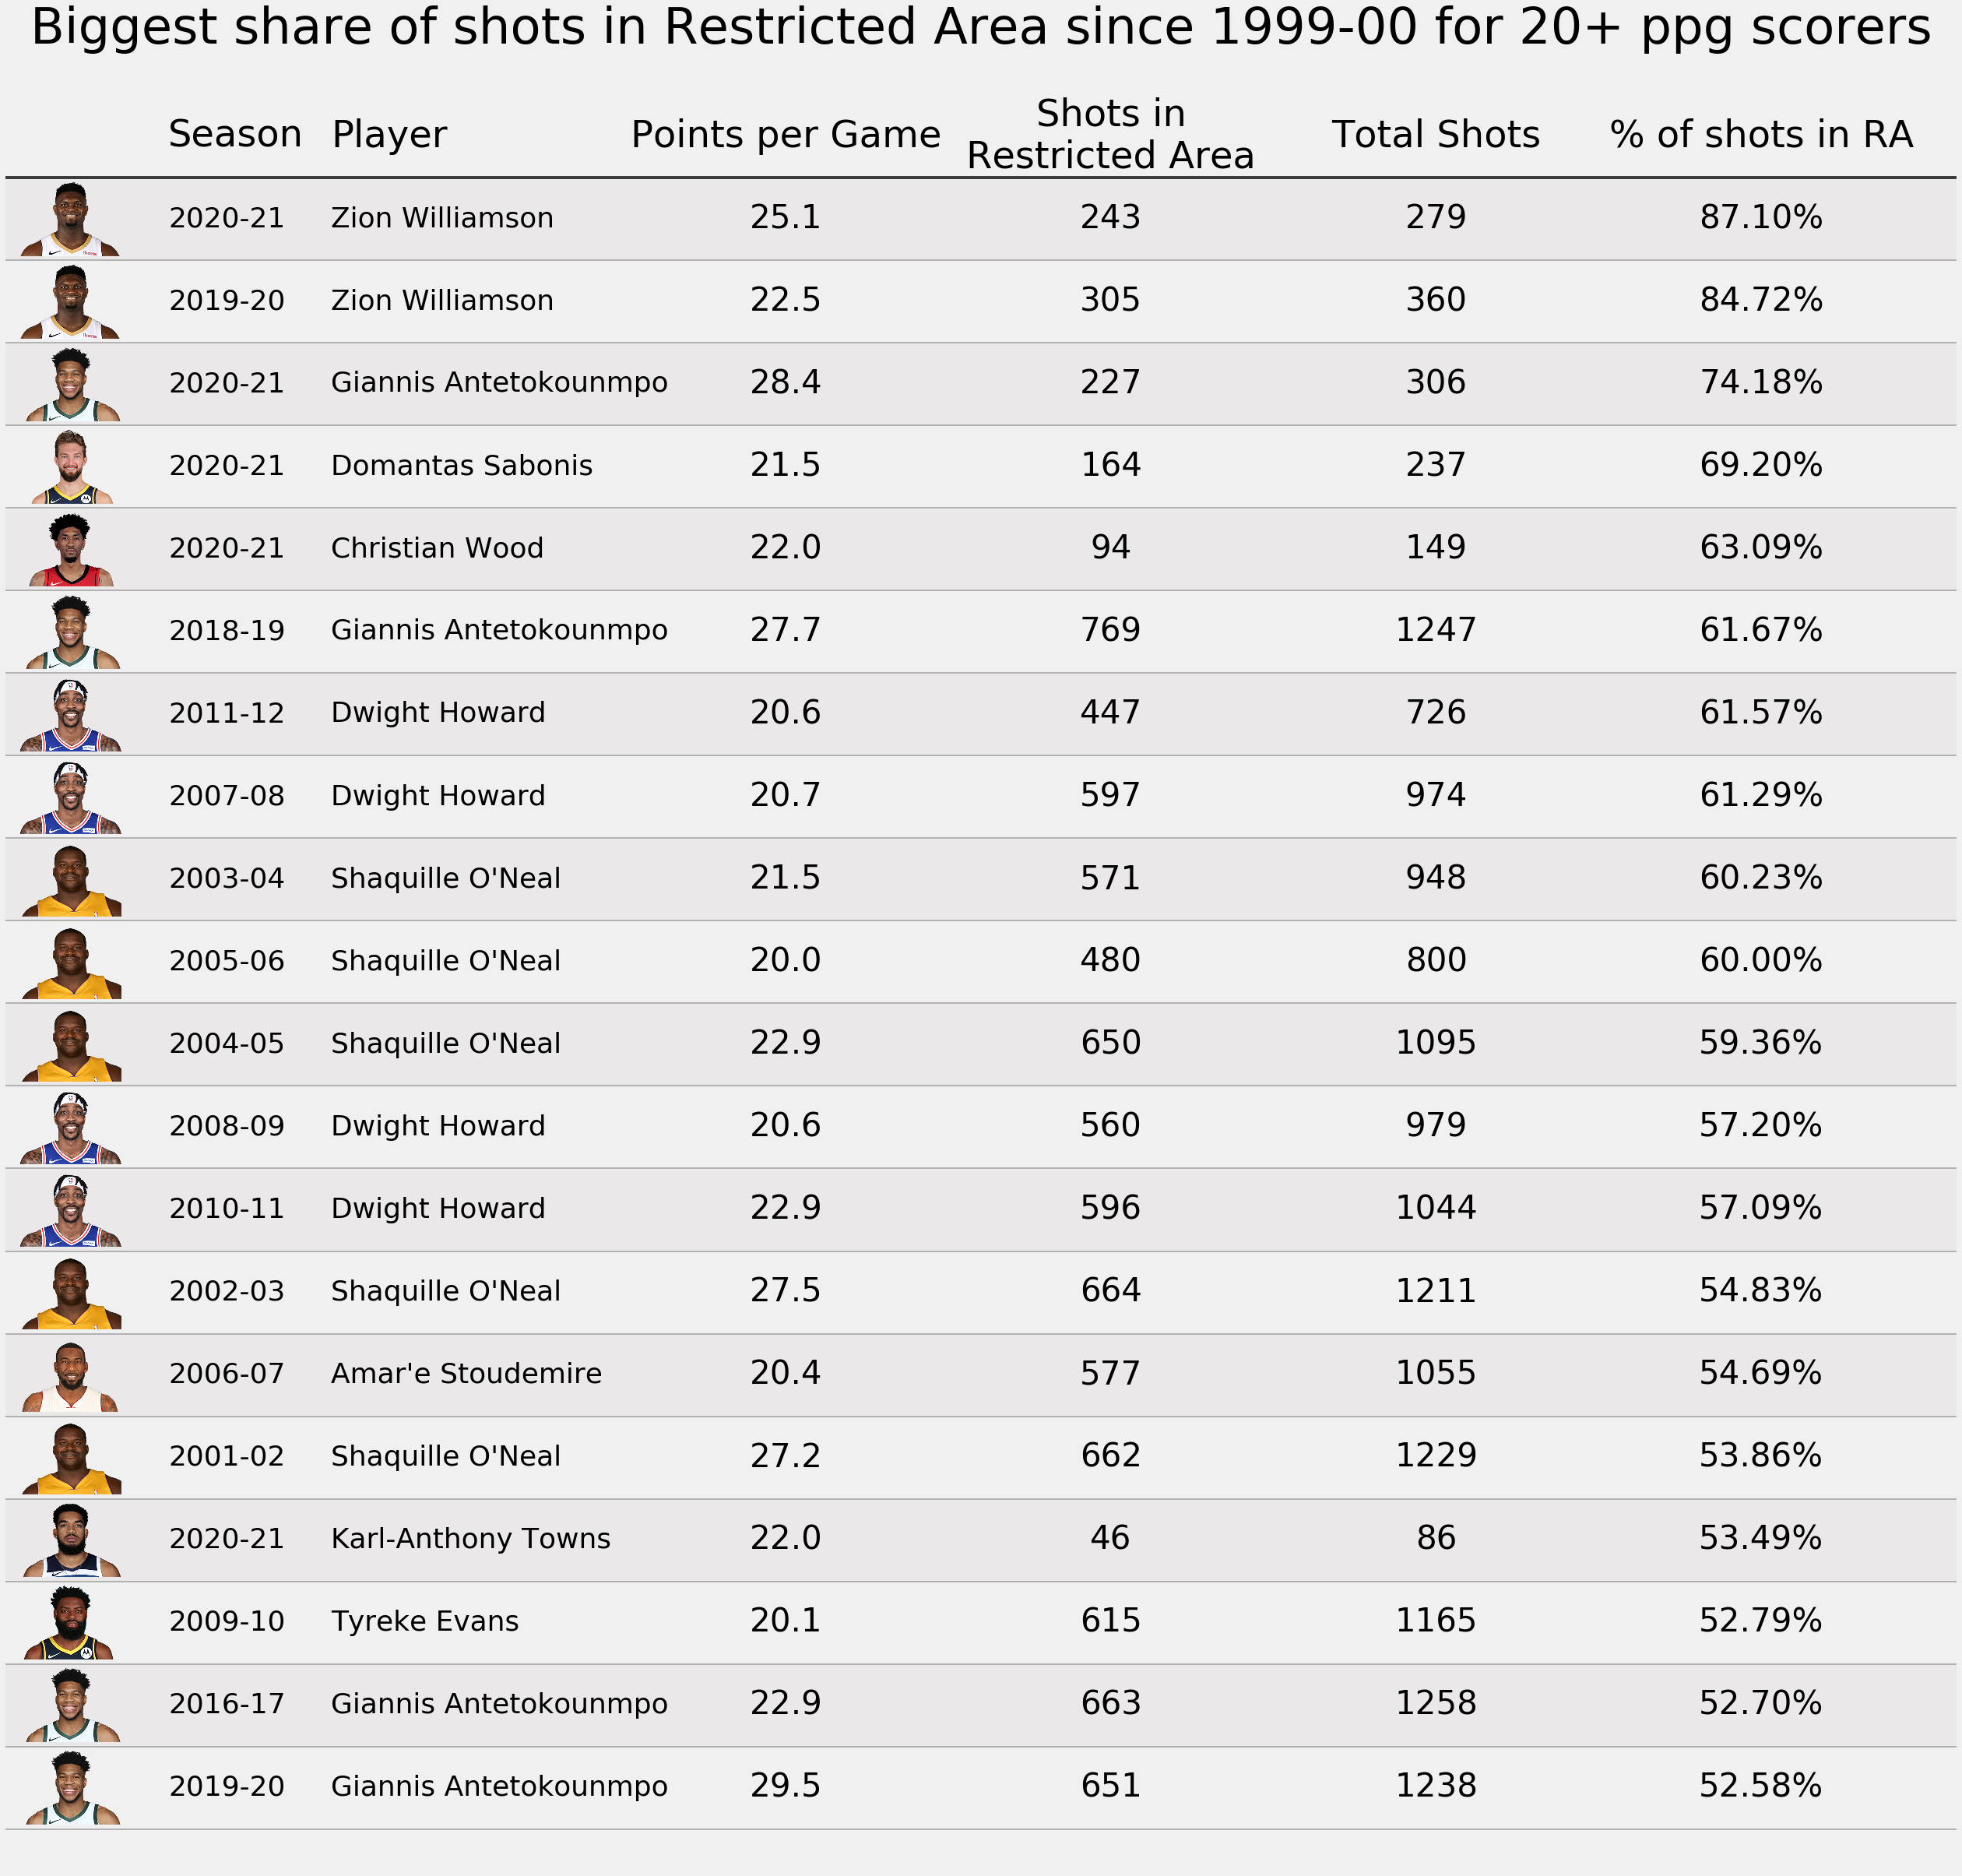

In [104]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = top_players
top = len(sorted_open_df)
for i in range(top):
    item = sorted_open_df.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
        
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.PTS}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.SHOT_ATTEMPTED_FLAG}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.TOTAL_SHOTS}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.SHOT_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Points per Game", size=font_title)
ax.text(x=1.7, y=top, ha='center', va='center', s="Shots in\nRestricted Area", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Total Shots", size=font_title)
ax.text(x=2.7, y=top, ha='center', va='center', s="% of shots in RA", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Biggest share of shots in Restricted Area since 1999-00 for 20+ ppg scorers", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=3)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_wo_luck.png', dpi=120, bbox_inches='tight')

In [85]:
top_players

,PLAYER_NAME,SEASON,SHOT_ZONE_BASIC,SHOT_MADE_FLAG,SHOT_ATTEMPTED_FLAG,TOTAL_SHOTS,SHOT_PCT,PLAYER_ID,PTS
3590,Zion Williamson,2020-21,Restricted Area,243,243,279,87.096774,1629627,25.1
3585,Zion Williamson,2019-20,Restricted Area,190,305,360,84.722222,1629627,22.5
1341,Giannis Antetokounmpo,2020-21,Restricted Area,227,227,306,74.183007,203507,28.4
1106,Domantas Sabonis,2020-21,Restricted Area,164,164,237,69.198312,1627734,21.5
700,Christian Wood,2020-21,Restricted Area,94,94,149,63.087248,1626174,22.0
1329,Giannis Antetokounmpo,2018-19,Restricted Area,567,769,1247,61.668003,203507,27.7
1153,Dwight Howard,2011-12,Restricted Area,296,447,726,61.570248,2730,20.6
1139,Dwight Howard,2007-08,Restricted Area,447,597,974,61.293634,2730,20.7
3108,Shaquille O'Neal,2003-04,Restricted Area,413,571,948,60.232068,406,21.5
3114,Shaquille O'Neal,2005-06,Restricted Area,363,480,800,60.000000,406,20.0


In [86]:
from pathlib import Path

In [91]:
player_ids = [406, 201936, 2405]

In [92]:
for index in tqdm.tqdm(range(len(top_players))):
    item = top_players.iloc[index]
    player_id = item.PLAYER_ID
    if player_id not in player_ids:
        continue
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    #img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.33it/s]


In [ ]:
a